<a href="https://colab.research.google.com/github/peritopaulomax/PRNU/blob/master/PRNU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementação do algoritmo descrito em  *M. Goljan, T. Filler, and J. Fridrich. Large Scale Test of Sensor Fingerprint Camera Identification. In N.D. Memon and E.J. Delp and P.W. Wong and J. Dittmann, editors, Proc. of SPIE, Electronic Imaging, Media Forensics and Security XI, volume 7254, January 2009*.

O código abaixo foi adaptado de https://dde.binghamton.edu/download/camera_fingerprint/ e está aqui disponível para fins **acadêmicos e de pesquisa**. Observe que o código está protegido pelas leis de direitos autorais dos Estados Unidos, sendo licenciado sob uma Licença Internacional Creative Commons Atribuição-NãoComercial 4.0, vedando o uso do código para fins comerciais sem a permissão expressa por escrito do titular dos direitos autorais. Para obter permissão, entre em contato com Scott Moser em smoser@binghamton.edu.

Adaptação do códio para uso em Jupiter Notebook com colaboração de:

Paulo Max Gil Innocencio Reis

Andrea Alves Guimarães Dresch

# **Importação das bibliotecas e funções necessárias. Bibliteca de funções deve estar carregada na pasta "*src*" após clonagem GIT**

In [ ]:
import os
def is_running_in_colab():
    return 'COLAB_GPU' in os.environ

iscolab=is_running_in_colab()

if iscolab:
    if os.path.exists('/content/PRNU'):
        !rm -rf {'/content/PRNU'}
    if not os.path.exists('/content/PRNU'):
        !git clone https://github.com/peritopaulomax/PRNU.git
    if not os.path.exists('/content/src'):
        !cp -R /content/PRNU/src /content/src
    if not os.path.exists('/content/padrao'):
        !mkdir /content/padrao
else:
    if not os.path.exists('./padrao'):
        !mkdir padrao
    if not os.path.exists('./src'):
        print("Instale a pasta 'src' a partir do repositorio em https://github.com/peritopaulomax/PRNU.git")

import src.Functions as Fu
import src.Filter as Ft
import src.getFingerprint as gF
import src.maindir as md
import src.extraUtils as eu
import numpy as np
import cv2 as cv
import pickle
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import scipy as sp
from IPython.display import clear_output




# **Utilize as celulas abaixo caso deseje calcular o PRNU de uma câmera alegada a partir de imagens padrão**



Definição dos caminhos da pasta contendo o material padrão (imagens coletadas a partir da câmera conhecida), As imagens padrão devem ser as mais homogêneas possivel (sem conteúdo em alta frequência), e submetidas a luminãncia elevada, sem saturação.

In [ ]:
if iscolab:
    caminho_pasta = '/content/padrao'
else:
    caminho_pasta ='./padrao'

lista = os.listdir(caminho_pasta)
padrao = [os.path.join(caminho_pasta, x) for x in lista]

Cálculo do padrão de PRNU da câmera que alegadamente é fonte da imagem questionada a partir das imagens padrão.

In [ ]:
RP,_,_ = gF.getFingerprint(padrao)
RP = Fu.rgb2gray1(RP)
sigmaRP = np.std(RP)
Fingerprint = Fu.WienerInDFT(RP, sigmaRP)
nome_arquivo_fingerprint = input("Digite o nome do arquivo para salvar PRNU: ")
if not nome_arquivo_fingerprint.endswith(".prnu"):
    nome_arquivo_fingerprint += ".prnu"

with open(nome_arquivo_fingerprint, 'wb') as arquivo:
    pickle.dump(Fingerprint, arquivo)

# **Utilize a célula abaixo caso deseje carregar um arquivo PRNU calculado anteriormente calculado**

  * Não é necessario recarregar se tiver acabado de gerar o arquivo PRNU no passo anterior


In [ ]:
if iscolab:
    with open('/content/camera1.prnu', 'rb') as arquivo:
        Fingerprint = pickle.load(arquivo)
else:
    with open('./camera1.prnu', 'rb') as arquivo:
        Fingerprint = pickle.load(arquivo)

# **Extração do resíduo de ruído da imagem questionada para comparação com o padrão PRNU da câmera alegada**

In [ ]:
if iscolab:
    questionado = '/content/m2-crop_escala.png'
else:
    questionado = 'm2-crop_escala.png'

Noisex = Ft.NoiseExtractFromImage(questionado, sigma=2.)
Noisex = Fu.WienerInDFT(Noisex, np.std(Noisex))


# **Escolha do modo de comparação entre padrão e questionado**

In [ ]:
def tratar_selecao(opcao):
  global selecao_radiobutton
  selecao_radiobutton = opcao
  print("Opção selecionada:", opcao)
# Criação da combobox com as opções
opcoes = ['Completa', 'Recortada', 'Recortada e Redimensionada']
radiobutton = widgets.RadioButtons(options=opcoes)

# Exibição da combobox
#display(radiobutton)
widgets.interact(tratar_selecao, opcao=radiobutton)


interactive(children=(RadioButtons(description='opcao', options=('Completa', 'Recortada', 'Recortada e Redimen…

<function __main__.tratar_selecao(opcao)>

# **Comparação entre questionado e padrão**

Razões máxima, atual e mínima:10.1880, 0.4468, 0.4458
A razão de reeescalnamento encontrada foi:0.599465
A imagem foi recortada em: X=100 e Y=196


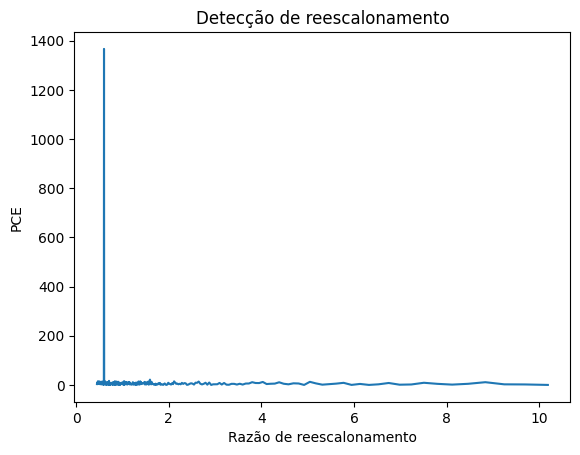

In [ ]:
Ix = cv.cvtColor(cv.imread(questionado),# image in BGR format
                 cv.COLOR_BGR2GRAY)

if selecao_radiobutton == "Recortada":
  A=Noisex
  B=Ix
  if Fingerprint.shape[0] > A.shape[0] or Fingerprint.shape[1] > A.shape[1]:
    A = np.pad(A, [(0, abs(Fingerprint.shape[0]-A.shape[0])), (0, abs(Fingerprint.shape[1]-A.shape[1]))])
    B = np.pad(B, [(0, abs(Fingerprint.shape[0]-B.shape[0])), (0, abs(Fingerprint.shape[1]-B.shape[1]))])
  C = Fu.crosscorr(A, B*Fingerprint)
  det, det0 = md.PCE(C, [Fingerprint.shape[0] - Noisex.shape[0], Fingerprint.shape[1] - Noisex.shape[1]])
elif selecao_radiobutton == "Completa":
    aux = Fingerprint
    if Ix.shape[0] > Ix.shape[1]:
        Ix = np.rot90(Ix,-1)
        Noisex = np.rot90(Noisex,-1)

    if Fingerprint.shape[1] > Ix.shape[1]:
        Fingerprint = cv.resize(Fingerprint, np.size(Ix), interpolation=cv.INTER_LINEAR)

    if np.size(Ix) != np.size(Fingerprint):
        raise ValueError("PRNU e Questionada com dimensões diferentes. Verifique outro método")

    C= Fu.crosscorr(Noisex,np.multiply(Ix, Fingerprint))
    det, det0 = md.PCE(C)
    Fingerprint = aux
elif selecao_radiobutton == "Recortada e Redimensionada":
    det_max = {"PCE": 0}
    rT = 1
    locT = [0, 0]
    rmax = 1 / max([Noisex.shape[0] / Fingerprint.shape[0], Noisex.shape[1]/ Fingerprint.shape[1]])
    r = 1
    i = 0
    pcepce=[]

    for r in np.arange(rmax - round((rmax - 0.1) / 0.005) * 0.005, rmax, 0.005):
        clear_output(wait=True)
        print(f'Razões máxima, atual e mínima:{1/(rmax - round((rmax - 0.1) / 0.005) * 0.005):.4f}, {1/r:.4f}, {1/rmax:.4f}')
        Nsized = cv.resize(Noisex, None, fx=r, fy=r, interpolation=cv.INTER_LANCZOS4)
        Ixsized = cv.resize(Ix, None, fx=r, fy=r, interpolation=cv.INTER_LANCZOS4)
        A=Nsized
        B=Ixsized
        if Fingerprint.shape[0] > A.shape[0] or Fingerprint.shape[1] > A.shape[1] and np.size(Ixsized)==np.size(Nsized):
          A = np.pad(A, [(0, abs(Fingerprint.shape[0]-A.shape[0])), (0, abs(Fingerprint.shape[1]-A.shape[1]))])
          B = np.pad(B, [(0, abs(Fingerprint.shape[0]-B.shape[0])), (0, abs(Fingerprint.shape[1]-B.shape[1]))])
        C = Fu.crosscorr(A, B*Fingerprint)
        if min([Fingerprint.shape[0] - Nsized.shape[0], Fingerprint.shape[1] - Nsized.shape[1]]) >= 0:
            det, det0 = md.PCE(C, [Fingerprint.shape[0] - Nsized.shape[0], Fingerprint.shape[1] - Nsized.shape[1]])
            loc = det['PeakLocation']
            C =  Fu.crosscorr(Nsized, Ixsized * Fingerprint[loc[0]:loc[0]+Ixsized.shape[0], loc[1]:loc[1]+Ixsized.shape[1]])
            det, det0 = md.PCE(C)
            pcepce.append(det['PCE'])
            if det['PCE'] > det_max['PCE']:
                det_max = det
                rT =1/r
                locT=loc
        i += 1
    det=det_max
    det['PeakLocation']=locT
    print(f'A razão de reeescalnamento encontrada foi:{rT:5f}')
    print(f'A imagem foi recortada em: X={locT[0]} e Y={locT[1]}')
    plt.plot(1/np.arange(rmax - round((rmax - 0.1) / 0.005) * 0.005, rmax, 0.005),pcepce)
    plt.xlabel('Razão de reescalonamento')
    plt.ylabel('PCE')
    plt.title('Detecção de reescalonamento')
    plt.show()

In [ ]:
for key in det.keys(): print("{0}: {1}".format(key, det[key]))
#Z =np.fft.fftshift(C)
#X = np.arange(Z.shape[0])
#Y = np.arange(Z.shape[1])
#X, Y = np.meshgrid(X, Y)
#fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111, projection='3d')
#ax.set_facecolor((0.7, 0.7, 0.7))
#cmap = LinearSegmentedColormap.from_list(
#    "mycmap", [(0, "blue"),(0.4, "white"), (0.7, "green"),(1, "red")]
#)
#ax.contour3D(X, Y, Z, 200, cmap=cmap)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')
#plt.show()

PCE: 1366.3487187855285
pvalue: 2.157533540560186e-299
PeakLocation: [100, 196]
peakheight: 0.05050737487731826
P_FA: 2.157533540560186e-299
log10P_FA: -298.6660424441101
